# DIME: Database on Ideology, Money in Politics, and Elections 

Dime is a general resource for the study of campaign finance and ideology in American politics. We will use three datasets from it to find some interesting insights. We will use Spark to analyze the data.


__Data source__: 

Bonica, Adam. 2016. Database on Ideology, Money in Politics, and Elections: Public version 2.0 [Computer file]. Stanford, CA: Stanford University Libraries. <https://data.stanford.edu/dime>

-----

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, desc, row_number

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
from IPython.display import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", 101)

% matplotlib inline

----

In [5]:
print("Application ID: ", str(sc.getConf().get('spark.app.id')))

('Application ID: ', 'application_1520096493376_0011')


In [6]:
sc.getConf().getAll()

[(u'spark.eventLog.enabled', u'true'),
 (u'spark.driver.extraLibraryPath',
  u'/usr/lib/hadoop/lib/native:/usr/lib/hadoop-lzo/lib/native'),
 (u'spark.driver.host', u'172.31.7.113'),
 (u'spark.blacklist.decommissioning.timeout', u'1h'),
 (u'spark.yarn.appMasterEnv.SPARK_PUBLIC_DNS', u'$(hostname -f)'),
 (u'spark.jars.packages', u''),
 (u'spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  u'ip-172-31-7-113.ec2.internal'),
 (u'spark.executor.cores', u'4'),
 (u'spark.executor.extraJavaOptions',
  u"-verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=70 -XX:MaxHeapFreeRatio=70 -XX:+CMSClassUnloadingEnabled -XX:OnOutOfMemoryError='kill -9 %p'"),
 (u'spark.eventLog.dir', u'hdfs:///var/log/spark/apps'),
 (u'spark.sql.hive.metastore.sharedPrefixes',
  u'com.amazonaws.services.dynamodbv2'),
 (u'spark.sql.warehouse.dir', u'hdfs:///user/spark/warehouse'),
 (u'spark.serializer.objectStreamReset', u'100

In [7]:
file_path="s3://lsdm-emr-util/lsdm-data/dime_recipients_all_1979_2014.csv"
dime_recipients = spark.read.csv(file_path, header=True)

file_path="s3://lsdm-emr-util/lsdm-data/vote_db.csv"
vote_db = spark.read.csv(file_path, header=True)

file_path="s3://lsdm-emr-util/lsdm-data/text_db.csv.gz"
text_db = spark.read.csv(file_path, header=True)

In [8]:
def print_row_count(dataset):
    "Print row count of dataset."
    
    dataset, dataset_name = dataset
    
    num_rows = dataset.count()
    print('\nThere are {} rows in {}.'.format(num_rows, dataset_name))
    
    return

def print_first_x_lines(dataset, x):
    "Print first x lines of dataset"
    
    dataset, dataset_name = dataset
    
    num_rows = dataset.count()
    print('First {} lines of {}:'.format(x, dataset_name))
    print(dataset.take(x))
    
    return

In [9]:
dataset_list = [(dime_recipients, "dime_recipients"), 
                (vote_db, "vote_db"), 
                (text_db, "text_db")]

for dataset in dataset_list:
    print_row_count(dataset)
    print_first_x_lines(dataset, 1)


There are 379763 rows in dime_recipients.
First 1 lines of dime_recipients:
[Row(election=u'fdfd1980', cycle=u'1980', fecyear=u'1978', Cand.ID=u'S8WY00072', FEC.ID=u'C00101774', NID=u'NS8WY00072', ICPSR=u'S8WY000721980', ICPSR2=u'S8WY00072', bonica.rid=u'cand107439', bonica.cid=None, name=u'whitaker, raymond b.', lname=u'whitaker', ffname=u'raymond b.', fname=u'raymond', mname=u'b', nname=None, title=None, suffix=None, party=u'100', state=u'WY', seat=u'federal:senate', district=u'WYS78', Incum.Chall=u'C', recipient.cfscore=None, contributor.cfscore=None, recipient.cfscore.dyn=None, dwnom1=None, dwnom2=None, ps.dwnom1=None, ps.dwnom2=None, dwdime=None, irt.cfscore=None, num.givers=None, num.givers.total=None, n.data.points.personal.donations=u'0', n.data.points.personal.donations.unq=u'0', cand.gender=u'M', total.disbursements=u'11124953', total.pc.contribs=u'0', contribs.from.candidate=u'0', unitemized=u'0', non.party.ind.exp.for=u'0', non.party.ind.exp.against=u'0', ind.exp.for=u'0',

In [10]:
# How many distinct names does the dime_recipients table have?
sc.setJobGroup("Get_Distinct_Names", "Get Distinct Names")
distinct_names = dime_recipients.select(dime_recipients["name"])\
                .distinct()\
                .count()
print('There are {} distinct names in dime_recipients.'.format(distinct_names))

dime_recipients.rdd.getNumPartitions()
sc.statusTracker().getJobIdsForGroup("Get_Distinct_Names")

There are 166352 distinct names in dime_recipients.


4

[12]

Based on the previous cell, we can see that the job-id of interest is: 12. The job action was the count action and  had a total of 3 stages out of which 3 succeeded.

![Distinct Names Overview](images/distinct_names_overview.png)

When looking at the three stages, we can see in which order they were done. As expected, the stages shuffling the data were done first. The result stage with ID 20 was done last. Across the 3 stages, 205 tasks were conducted successfully.

![Distinct Names Stages](images/distinct_names_stages.png)

The stages were dependent on each other as indicated by the DAG. We only have one executor executing all tasks of the 3 stages. This can be observed from the timeline where we only see one executor being added.

When we take a closer look at stage 18, we see the following:
![Distinct Names Stage 18](images/distinct_names_stage_18.png)

Stage 18 has 4 tasks that run on one machine. Most of the task's time is spent on computation and all tasks finish around the same time.

When we take a closer look at stage 20, the last stage, we see the following:
![Distinct Names Stage 20](images/distinct_names_stage_20.png)

Stage 18 has 1 task that runs on one machine. Most of the task's time is spent on computation, but we now observe a good amount of time spend on _task deserialization_. Since this is the last task and we have to collect all the previous information from the shuffles, this seems intuitive.

I am actually a little surprised to see only one executor. However, spark.dynamicAllocation.enabled is set to True, so that more executors should be used in later jobs when needed. Lets see how that plays out.



----
## Lets get an understanding of the tables.

1) What are their columns?

2) What does the data look like?

3) Lets play with some queries.

In [11]:
vote_db.columns

['vote_id',
 'bill_id',
 'bonica_rid',
 'Name',
 'party',
 'sponsor',
 'cosponsor',
 'vote_date',
 'vote_choice',
 'vs_idealPoint',
 'vs_cuttingpoint',
 'vs_rcdir']

In [12]:
text_db.columns

['doc.id',
 'doc.type',
 'bonica.rid',
 'bill.id',
 'sponsor.rid',
 'page.id',
 'congno',
 'legis.body',
 'training.set',
 'date',
 'text',
 'stemmed.text',
 'doc.labels',
 'tw.latent1',
 'tw.abortion.and.social.conservatism',
 'tw.agriculture',
 'tw.banking.and.finance',
 'tw.civil.rights',
 'tw.congress.and.procedural',
 'tw.crime',
 'tw.defense.and.foreign.policy',
 'tw.economy',
 'tw.education',
 'tw.energy',
 'tw.environment',
 'tw.fair.elections',
 'tw.federal.agencies.and.gov.regulation',
 'tw.guns',
 'tw.healthcare',
 'tw.higher.education',
 'tw.immigration',
 'tw.indian.affairs',
 'tw.intelligence.and.surveillance',
 'tw.labor',
 'tw.law.courts.and.judges',
 'tw.transportation',
 'tw.veterans.affairs',
 'tw.womens.issues']

In [13]:
dime_recipients.columns

['election',
 'cycle',
 'fecyear',
 'Cand.ID',
 'FEC.ID',
 'NID',
 'ICPSR',
 'ICPSR2',
 'bonica.rid',
 'bonica.cid',
 'name',
 'lname',
 'ffname',
 'fname',
 'mname',
 'nname',
 'title',
 'suffix',
 'party',
 'state',
 'seat',
 'district',
 'Incum.Chall',
 'recipient.cfscore',
 'contributor.cfscore',
 'recipient.cfscore.dyn',
 'dwnom1',
 'dwnom2',
 'ps.dwnom1',
 'ps.dwnom2',
 'dwdime',
 'irt.cfscore',
 'num.givers',
 'num.givers.total',
 'n.data.points.personal.donations',
 'n.data.points.personal.donations.unq',
 'cand.gender',
 'total.disbursements',
 'total.pc.contribs',
 'contribs.from.candidate',
 'unitemized',
 'non.party.ind.exp.for',
 'non.party.ind.exp.against',
 'ind.exp.for',
 'ind.exp.against',
 'comm.cost.for',
 'comm.cost.against',
 'party.coord.exp',
 'party.ind.exp.against',
 'total.receipts',
 'total.indiv.contrib',
 'total.pac.contribs',
 'ran.primary',
 'ran.general',
 'p.elec.stat',
 's.elec.stat',
 'r.elec.stat',
 'gen.elec.stat',
 'gen.elect.pct',
 'winner',
 'dis

Here is some background on some of the interesting columns:

1) election: Election cycle preceded by two-letter state code. Federal candidates have ’fd’ as the state code.

2) cycle: Four digit number that indicates the two-year election cycle during which the contribution was recorded.

3) fecyear: Year listed by the FEC indicating the year of campaign’s the target election. The ’election’ variable indicates the election cycle during which the contribution was received. But the election can occur in a future cycle—as is the case for senators that fundraise during their first four years in office.

46) comm.cost.for: total communication costs made on behalf of the candidate.

47) comm.cost.against: total communication costs made to oppose the candidate.

48) party.coord.exp: total party coordinated expenditures.

49) party.ind.exp.against: total independent expenditures made by opposing party against the candidate.

50) total.receipts: total dollars raised by candidate during an election cycle.

51) total.indiv.contributions: total individual receipts.

52) total.pac.contributions: total PAC receipts.

In [14]:
# Lets use Spark SQL.
vote_db.createOrReplaceTempView("vote_db")
dime_recipients.createOrReplaceTempView("dime_recipients")
text_db.createOrReplaceTempView("text_db")

sqlDF = spark.sql("SELECT * FROM vote_db limit 3")
sqlDF.toPandas() #prettier output

sqlDF = spark.sql("SELECT * from dime_recipients limit 3")
sqlDF.toPandas()

sqlDF = spark.sql("SELECT * from text_db limit 3")
sqlDF.toPandas()

,vote_id,bill_id,bonica_rid,Name,party,sponsor,cosponsor,vote_date,vote_choice,vs_idealPoint,vs_cuttingpoint,vs_rcdir
0,cand1000_110_,110_,cand1000,"ARCURI, MICHAEL ANGELO",100,0,0,2007-01-04,1,-0.198377683214566,-0.198377683214566,6
1,cand1000_110_adjourn,110_adjourn,cand1000,"ARCURI, MICHAEL ANGELO",100,0,0,2007-01-18,1,-0.249578618383168,-0.249578618383168,6
2,cand1000_110_hconres103,110_hconres103,cand1000,"ARCURI, MICHAEL ANGELO",100,0,0,2007-03-29,1,-0.245425955675414,-0.245425955675414,6


,election,cycle,fecyear,Cand.ID,FEC.ID,NID,ICPSR,ICPSR2,bonica.rid,bonica.cid,...,igcat,comtype,nimsp.party,nimsp.candidate.ICO.code,nimsp.district,nimsp.office,nimsp.candidate.status,before.switch.ICPSR,after.switch.ICPSR,party.orig
0,fdfd1980,1980,1978,S8WY00072,C00101774,NS8WY00072,S8WY000721980,S8WY00072,cand107439,None,...,None,S,None,None,None,None,None,None,None,100
1,fdfd1980,1980,1978,S8WY00064,C00104539,NS8WY00064,S8WY000641980,S8WY00064,cand107438,3822461216,...,None,S,None,None,None,None,None,None,None,100
2,fdfd1980,1980,1978,S8WY00056,C00102673,NS8WY00056,S8WY000561980,S8WY00056,cand107437,None,...,None,S,None,None,None,None,None,None,None,200


,doc.id,doc.type,bonica.rid,bill.id,sponsor.rid,page.id,congno,legis.body,training.set,date,...,tw.healthcare,tw.higher.education,tw.immigration,tw.indian.affairs,tw.intelligence.and.surveillance,tw.labor,tw.law.courts.and.judges,tw.transportation,tw.veterans.affairs,tw.womens.issues
0,cand1360_108_hres199_,speech,cand1360,108_hres199,cand511,S8575; vol: 149; num: 95; pages: S8575-S8577,108,US Senate,1,2003-06-25,...,0,0,0.0316140835765891,0,0,0,0.000497849467861472,0,0,0
1,cand742_108_sres184_,speech,cand742,108_sres184,cand742,S8575; vol: 149; num: 95; pages: S8575-S8577,108,US Senate,1,2003-06-25,...,0,0,0.0879999479403703,0,0,0,0.0000615790013098146,0,0,0
2,cand351_108_e_,speech,cand351,108_,None,S8575; vol: 149; num: 95; pages: S8575-S8577,108,US Senate,0,2003-06-25,...,0.000178143610656559,0.0000892268132056692,0.00221692506340308,0.000249768732695405,0.000992738894926748,0.000900914764237804,0.00959164547795757,0.017503642489415,0.0000638221656755272,0.000296436757580464


## Lets look at the information for Barack Obama

In [15]:
obamaDF = spark.sql("select * from dime_recipients where name = 'obama, barack'")
obamaDF.createOrReplaceTempView("obamaDF")

# What do his contributions look like?
query = """
SELECT election, cycle, fecyear, `num.givers`, `total.indiv.contrib` 
from obamaDF
order by cycle, election
"""

sqlDF = spark.sql(query)
sqlDF.show()

+--------+-----+-------+----------+-------------------+
|election|cycle|fecyear|num.givers|total.indiv.contrib|
+--------+-----+-------+----------+-------------------+
|    1996| 1996|   1996|        54|              39785|
|fdfd2000| 2000|   2000|       410|             475235|
|fdfd2000| 2000|   2000|       410|             475235|
|    2002| 2002|   2002|       236|              70025|
|fdfd2002| 2002|   2000|       236|                  0|
|fdfd2002| 2002|   2000|       236|                  0|
|    2004| 2004|   2004|      7931|                500|
|fdfd2004| 2004|   2004|      7931|           13611700|
|fdfd2004| 2004|   2004|      7931|           13611700|
|fdfd2006| 2006|   2010|       817|            1159359|
|fdfd2006| 2006|   2010|       817|            1159359|
|fdfd2008| 2008|   2008|    388029|       664872382.27|
|fdfd2008| 2008|   2010|    388029|              51799|
|fdfd2010| 2010|   2010|        28|                  0|
|fdfd2010| 2010|   2010|        28|             

## How do contributions compare across parties?

In [16]:
query = """
SELECT party, 
        sum(`num.givers`) as num_givers_sum,
        sum(`comm.cost.for`) as comm_cost_for_sum,
        sum(`party.ind.exp.against`) as party_exp_against_sum,
        sum(`total.receipts`) as total_receipts_sum,
        sum(`total.pac.contribs`) as total_pac_contribs,
        sum(`total.indiv.contrib`) as total_ind_contribs
        
from dime_recipients
where party in (100, 200)
group by 1
"""

sqlDF = spark.sql(query)
sqlDF.toPandas() #prettier prints

,party,num_givers_sum,comm_cost_for_sum,party_exp_against_sum,total_receipts_sum,total_pac_contribs,total_ind_contribs
0,200,13411966.0,17822712.0,2.977302e+10,1.970454e+10,4.546978e+09,9.999117e+09
1,100,19820800.0,36100653.0,2.972601e+10,2.093759e+10,4.827355e+09,1.114334e+10


## What is the latest information we can get?

In [17]:
dime_recipients.agg({"cycle": "max"}).collect()[0]

Row(max(cycle)=u'C')

In [18]:
# That result was surprising... what other weird values do exist in cycle?
dime_recipients.select(dime_recipients["cycle"]).distinct().show()

+-----+
|cycle|
+-----+
| 2016|
| 2012|
| 2020|
| 1988|
| 2014|
| 1984|
| 1982|
| 2000|
| 2002|
| 2018|
| 2006|
|    C|
| 2004|
| 1992|
| 2008|
| 1994|
| 1996|
| 1980|
|    1|
| 1986|
+-----+
only showing top 20 rows



In [19]:
# C and 1 are the only weird ones. What do their rows look like?
query = """
SELECT *
from dime_recipients
where cycle in ('C', 1)
"""
spark.sql(query).show()

+--------------------+-----+-------+-------+------+----+-----+------+----------+----------+----+-----+------+-----+----------+-----+-----+------+-----+-----+----+--------+-----------+-----------------+-------------------+---------------------+------+------+---------+---------+------+-----------+----------+----------------+--------------------------------+------------------------------------+-----------+-------------------+-----------------+-----------------------+----------+---------------------+-------------------------+-----------+---------------+-------------+-----------------+---------------+---------------------+--------------+-------------------+------------------+-----------+-----------+-----------+-----------+-----------+-------------+-------------+------+---------------------+----------------+----------+--------------+-----+-------+-----------+------------------------+--------------+------------+----------------------+-------------------+------------------+----------+
|       

In [20]:
# Not too many entries, so we will just filter them out.
query = """
SELECT *
from dime_recipients
where cycle not in ('C', 1)
"""
dime_recipients = spark.sql(query)

# Cycle is also a string right now. Lets change that.
dime_recipients = dime_recipients.withColumn("cycle", dime_recipients["cycle"].cast(IntegerType()))

# What is our max value now?
dime_recipients.agg({"cycle": "max"}).collect()[0]

Row(max(cycle)=2020)

In [21]:
dime_recipients.select(dime_recipients["cycle"]).distinct().sort(desc("cycle")).show()

+-----+
|cycle|
+-----+
| 2020|
| 2018|
| 2016|
| 2014|
| 2012|
| 2010|
| 2008|
| 2006|
| 2004|
| 2002|
| 2000|
| 1998|
| 1996|
| 1994|
| 1992|
| 1990|
| 1988|
| 1986|
| 1984|
| 1982|
+-----+
only showing top 20 rows



### Looking better!

----

## We now want to see how the volume of votes, etc., impacts the contributions someone receives.

For that, we need to merge the two dataset vote_db and dime_recipients based on bonica_rid. 

- Because dime_recipients has column names with dots in it, we should replace the dots with underscores first. 
- We also need to match vote dates to election cycles. We will make the simplyifing assumption that election cycles end at the end of the respective year. For example, we will match a vote date of 2007-3-4 to the election cycle 2008 and a vote date of 2008-3-4 to the election cycle 2008.

In [22]:
# changing the column names to replace dots by underscores
for col in dime_recipients.columns:
    if col.find(".") > 0:
        new_name = col.replace(".", "_")
        dime_recipients = dime_recipients.withColumnRenamed(col, new_name)
        
dime_recipients.createOrReplaceTempView("dime_recipients")

In [23]:
# Registering user defined function (UDF) to extract year from string
def extract_year_typed(date_string):
    "Extract year from date_string."
    year = int(date_string[:date_string.find('-')])
    if year % 2 == 0:
        return year
    return year + 1

def party_int_to_string(party):
    "Convert party variable to string."
    if party == "100":
        return 'Dem'
    elif party == "200":
        return 'Rep'
    elif party == "328":
        return 'Ind' 

sqlContext.udf.register("extractYear", extract_year_typed, IntegerType())
sqlContext.udf.register("party_int_to_string", party_int_to_string, StringType())

In [26]:
# A quick check if it worked.
query = """
SELECT vote_date, extractYear(vote_date) as matching_cycle
from vote_db
limit 2
"""
spark.sql(query).toPandas()

,vote_date,matching_cycle
0,2007-01-04,2008
1,2007-01-18,2008


In [27]:
query = """
SELECT bonica_rid, 
        sponsor, 
        cosponsor, 
        vote_choice,
        extractYear(vote_date) as cycle
from vote_db
where vote_date != 'NA'
"""
filtered_vote_db = spark.sql(query)
filtered_vote_db.createOrReplaceTempView("filtered_vote_db")

### Do you remember from above how Barack Obama had multiple entries for a cycle? For now, we will only consider the entry with the largest number of givers.

In [28]:
query = """
SELECT election, cycle, fecyear, `num.givers`, `bonica.rid`
from obamaDF
order by cycle, election
"""
spark.sql(query).toPandas().head(10)

,election,cycle,fecyear,num.givers,bonica.rid
0,1996,1996,1996,54,cand3335
1,fdfd2000,2000,2000,410,cand3335
2,fdfd2000,2000,2000,410,cand3335
3,2002,2002,2002,236,cand3335
4,fdfd2002,2002,2000,236,cand3335
5,fdfd2002,2002,2000,236,cand3335
6,2004,2004,2004,7931,cand3335
7,fdfd2004,2004,2004,7931,cand3335
8,fdfd2004,2004,2004,7931,cand3335
9,fdfd2006,2006,2010,817,cand3335


In [29]:
w = Window().partitionBy("cycle", "bonica_rid").orderBy(desc("num_givers"))

sc.setJobGroup("Filtering_Dime_Recipients", "Filtering_Dime_Recipients")
filtered_dime_recps = dime_recipients.withColumn("rn", row_number()\
                                        .over(w))\
                                        .where("rn == 1")
    
filtered_dime_recps.createOrReplaceTempView("filtered_dime_recps")

In [30]:
sc.setJobGroup("Join_Data", "Join_Data")
joined_data = filtered_vote_db.join(filtered_dime_recps, 
                                    ["cycle", "bonica_rid"])

joined_data.createOrReplaceTempView("joined_data")

In [31]:
query = """
SELECT *
from joined_data
limit 3
"""
spark.sql(query).toPandas()

,cycle,bonica_rid,sponsor,cosponsor,vote_choice,election,fecyear,Cand_ID,FEC_ID,NID,...,comtype,nimsp_party,nimsp_candidate_ICO_code,nimsp_district,nimsp_office,nimsp_candidate_status,before_switch_ICPSR,after_switch_ICPSR,party_orig,rn
0,2002,cand1526,0,0,6,fdfd2002,2002,H8NV01071,C00325738,N00009818,...,H,None,None,None,None,None,None,None,100,1
1,2002,cand1526,0,0,1,fdfd2002,2002,H8NV01071,C00325738,N00009818,...,H,None,None,None,None,None,None,None,100,1
2,2002,cand1526,0,0,1,fdfd2002,2002,H8NV01071,C00325738,N00009818,...,H,None,None,None,None,None,None,None,100,1


In [32]:
# It would have been cheaper to do this before, but didnt think of it.
joined_data.stat.freqItems(['vote_choice']).show()

+---------------------+
|vote_choice_freqItems|
+---------------------+
|               [1, 6]|
+---------------------+



#### We will have to note for later that the vote choice is either 1 or 6  with 1 being a yes and 6 a No.

## How many partitions is our data distributed over?

(*) Include a join of at least two of the data sources. Once you have completed your merge of the datasets, how many partitions is that merged data split across? How can you tell?

In [33]:
joined_data.rdd.getNumPartitions()
print(joined_data.storageLevel)

200

Serialized 1x Replicated


The joined data is distributed over 200 partitions and its storage level is Serialized 1x Replicated.

An overview of the 3 stages that were done for the join:

![Join - Stage Overview](images/join_data_overview.png)

In stage 52, we can see our window function having an impact.

A closer look at stage 50:

![Join - Stage 50](images/join_data_stage_50.png)

At the beginning of this stage, we have a FileScanRDD. It is an RDD that scans a list of file partitions. This gets followed directly by a MapPartitionsRDD in the same task. A MapPartitionsRDD is an RDD that applies a function to every partition of the parent RDD. (https://jaceklaskowski.gitbooks.io/mastering-apache-spark/content/spark-rdd-mappartitionsrdd.html)

We can also see that both tasks get called because of a later toPandas action.

#### We can also take a look at the job for calculating the frequent items.

This one is interesting because we can see that we are using multiple executors! It is also a good visualization of Spark's feature called dynamic allocation. It allows "Spark to scale the number of executors dynamically based on the workload such that cluster resources are shared more efficiently". (https://databricks.com/blog/2015/06/22/understanding-your-spark-application-through-visualization.html)

![Frequent Item Timeline](images/freq_item_timeline.png)


# Grouped aggregation
(*) Include a grouped aggregation, calculating some summary statistics of some continuous variable(s) by a categorical variable.

In [34]:
sc.setJobGroup("Calc_Grouped_Agg", "Calc_Grouped_Agg")
query = """
SELECT cycle,
        party_int_to_string(party) as party,
        
        sum(sponsor) as sponsor_vote_sum, 
        avg(sponsor) as sponsor_vote_avg, 
        
        sum(cosponsor) as cosponsor_vote_sum,
        avg(cosponsor) as cosponsor_vote_avg, 
        
        sum(num_givers) as num_givers_sum,
        avg(num_givers) as num_givers_avg,
        
        sum(comm_cost_for) as comm_cost_for_sum,
        sum(party_ind_exp_against) as party_exp_against_sum,
        sum(total_receipts) as total_receipts_sum,
        sum(total_pac_contribs) as total_pac_contribs,
        sum(total_indiv_contrib) as total_ind_contribs
        
from joined_data
where party in (100, 200, 328)
group by 1, 2
order by 1, 2
"""
result_df = spark.sql(query)
result_df.rdd.getNumPartitions()
print(result_df.storageLevel)
result = result_df.toPandas()

result

19

Serialized 1x Replicated


,cycle,party,sponsor_vote_sum,sponsor_vote_avg,cosponsor_vote_sum,cosponsor_vote_avg,num_givers_sum,num_givers_avg,comm_cost_for_sum,party_exp_against_sum,total_receipts_sum,total_pac_contribs,total_ind_contribs
0,2002,Dem,29.0,0.000507,2204.0,0.038527,29706780.0,521.519258,543348209.0,6.180354e+10,6.142919e+10,2.419847e+10,3.125247e+10
1,2002,Ind,0.0,0.000000,0.0,0.000000,NaN,NaN,0.0,6.156000e+07,0.000000e+00,0.000000e+00,0.000000e+00
2,2002,Rep,238.0,0.003977,4457.0,0.074486,32386156.0,545.065486,156369075.0,8.482165e+10,6.098865e+10,2.200944e+10,3.231364e+10
3,2004,Dem,19.0,0.000277,1492.0,0.021722,48579485.0,712.225619,189834861.0,7.898065e+10,8.780356e+10,2.719418e+10,5.204956e+10
4,2004,Rep,316.0,0.004102,4453.0,0.057800,48817126.0,637.673908,650547158.0,9.896664e+10,1.392721e+11,3.539762e+10,8.363316e+10
5,2006,Dem,22.0,0.000355,1772.0,0.028619,42899629.0,699.545520,730068712.0,6.229342e+10,8.848601e+10,2.842423e+10,5.215487e+10
6,2006,Ind,0.0,0.000000,10.0,0.035088,67545.0,237.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,2006,Rep,282.0,0.003910,4331.0,0.060056,48829759.0,681.846552,437440833.0,1.275421e+11,1.068417e+11,4.026728e+10,5.562515e+10
8,2008,Dem,563.0,0.003527,13387.0,0.083872,120627950.0,763.250656,0.0,0.000000e+00,2.425407e+11,1.083745e+11,1.222479e+11
9,2008,Rep,102.0,0.000748,5138.0,0.037676,92864186.0,682.468608,0.0,0.000000e+00,2.046053e+11,7.698194e+10,1.095105e+11


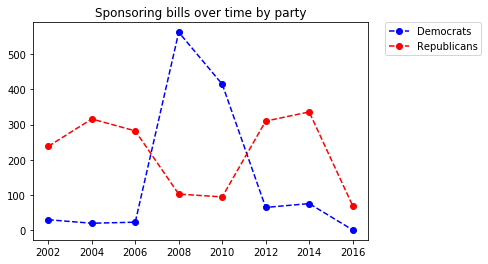

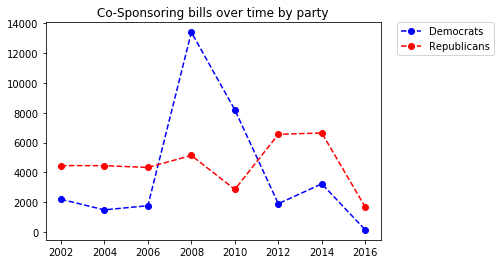

In [35]:
dem_result = result[result.party == 'Dem']
rep_result = result[result.party == 'Rep']
all_cycles = dem_result.cycle.values

def plot_function(column, dem_result, rep_result, title):
    _ = plt.plot(dem_result[column].values, '--bo')
    _ = plt.plot(rep_result[column].values, '--ro')
    _ = plt.xticks([i for i in range(len(all_cycles))], all_cycles)

    _ = plt.title(title)
    _ = plt.legend(['Democrats', 'Republicans'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    _ = plt.show()
    

plot_function('sponsor_vote_sum', dem_result, rep_result, 'Sponsoring bills over time by party')   
plot_function('cosponsor_vote_sum', dem_result, rep_result, 'Co-Sponsoring bills over time by party')   

-----
#### What is interesting to me is that the Democrats sponsored/cosponsored a lot less started in 2012 cycle. I assume that this is related to the Republicans winning the House - however, with the Democrats still controlling the Senate I would have assumed that they continue to sponsor bills more.

-----
The grouped data is distributed over 19 partitions - a lot less than our previous 200 partitions. This makes sense, as the resuling dataset is a lot smaller than before. It actually somewhat surprising since the dataset has only 18 rows and not that many columns...

What is interesting to see is that for the toPandas action, some stages were skipped as they were already computed for the call to get the number of partitions. This is indicating by the gray background of the stages and also mentinoed in the lower half of the table (not shown here).

![Grouped Data - Skipped stages](images/grouped_data_skipped.png)

A general note: Tasks named _WholeStageCodegen_ fuse "multiple operators (as a subtree of plans that support codegen) together into a single Java function that is aimed at improving execution performance". https://stackoverflow.com/questions/40590028/what-do-the-blue-blocks-in-spark-stage-dag-visualisation-ui-mean

----

## How many bills are introduced over time and what does the other party, i.e., the party that did not sponsor the bill, vote like?

In [36]:
query = """
SELECT x.bill_id as bill_id, year(x.vote_date) as year, 
        case
            when month(x.vote_date) < 7 then 1
            else 2
        end as half_year, 
        x.bonica_rid as sponsor_bonica_rid, x.Name as sponsor_name, x.party as sponsor_party, 
        x.sponsor as sponsor_sponsor, x.cosponsor as sponsor_cosponsor,
        x.vote_choice as sponsor_vote_choice,
        y.bonica_rid as other_bonica_rid, y.Name as other_name, y.party as other_party, 
        y.sponsor as other_sponsor, y.cosponsor as other_cosponsor, 
        case
            when y.vote_choice = 1 then 1
            else 0
        end as other_vote_choice
from vote_db x
join vote_db y
    using (bill_id)
where x.vote_id != y.vote_id 
    and x.vote_choice = 1 
    and x.party != y.party
    and x.sponsor = 1
    and x.bonica_rid != 'NA'
    and y.bonica_rid != 'NA'
    and x.party in (100,200)
    and y.party in (100,200)
"""

across_the_isle = spark.sql(query)
across_the_isle.createOrReplaceTempView("across_the_isle")
sqlContext.cacheTable("across_the_isle")

query = """
SELECT *
from across_the_isle
limit 2
"""
spark.sql(query).toPandas()

,bill_id,year,half_year,sponsor_bonica_rid,sponsor_name,sponsor_party,sponsor_sponsor,sponsor_cosponsor,sponsor_vote_choice,other_bonica_rid,other_name,other_party,other_sponsor,other_cosponsor,other_vote_choice
0,107_hr3394,2002,1,cand593,"BOEHLERT, SHERWOOD L",200,1,0,1,cand1188,"DINGELL, JOHN D.",100,0,0,1
1,107_hr3394,2002,1,cand593,"BOEHLERT, SHERWOOD L",200,1,0,1,cand1190,"CRAMER, ROBERT E JR",100,0,0,1


#### Just a quick check on what the table looks like.

In [38]:
query = """
with number_of_bills as (
    select year, 
            half_year, 
            sponsor_party, 
            count(bill_id) as sum_bills
    from (
        SELECT distinct year,
                half_year,
                sponsor_party,
                bill_id
        from across_the_isle)
    group by 1,2,3)
    
SELECT year, half_year,
        party_int_to_string(sponsor_party) as sponsor_party,
        sum_bills,
        party_int_to_string(other_party) as other_party,
        
        count(other_vote_choice) as total_votes_from_opp_party,
        sum(other_vote_choice) as total_yes_votes_from_opp_party,
        
        count(other_vote_choice) / sum_bills as opp_total_votes_per_bill,
        sum(other_vote_choice) / sum_bills as opp_yes_votes_per_bill,
        
        sum(other_vote_choice) / count(other_vote_choice) as share_of_yes_votes_opp_party
        
from across_the_isle
join number_of_bills 
    using (year, half_year, sponsor_party)
group by 1,2,3,4,5
order by 1,2,3
"""

voting_behavior = spark.sql(query)
voting_behavior.createOrReplaceTempView("voting_behavior")
sqlContext.cacheTable("voting_behavior")
result = voting_behavior.toPandas()

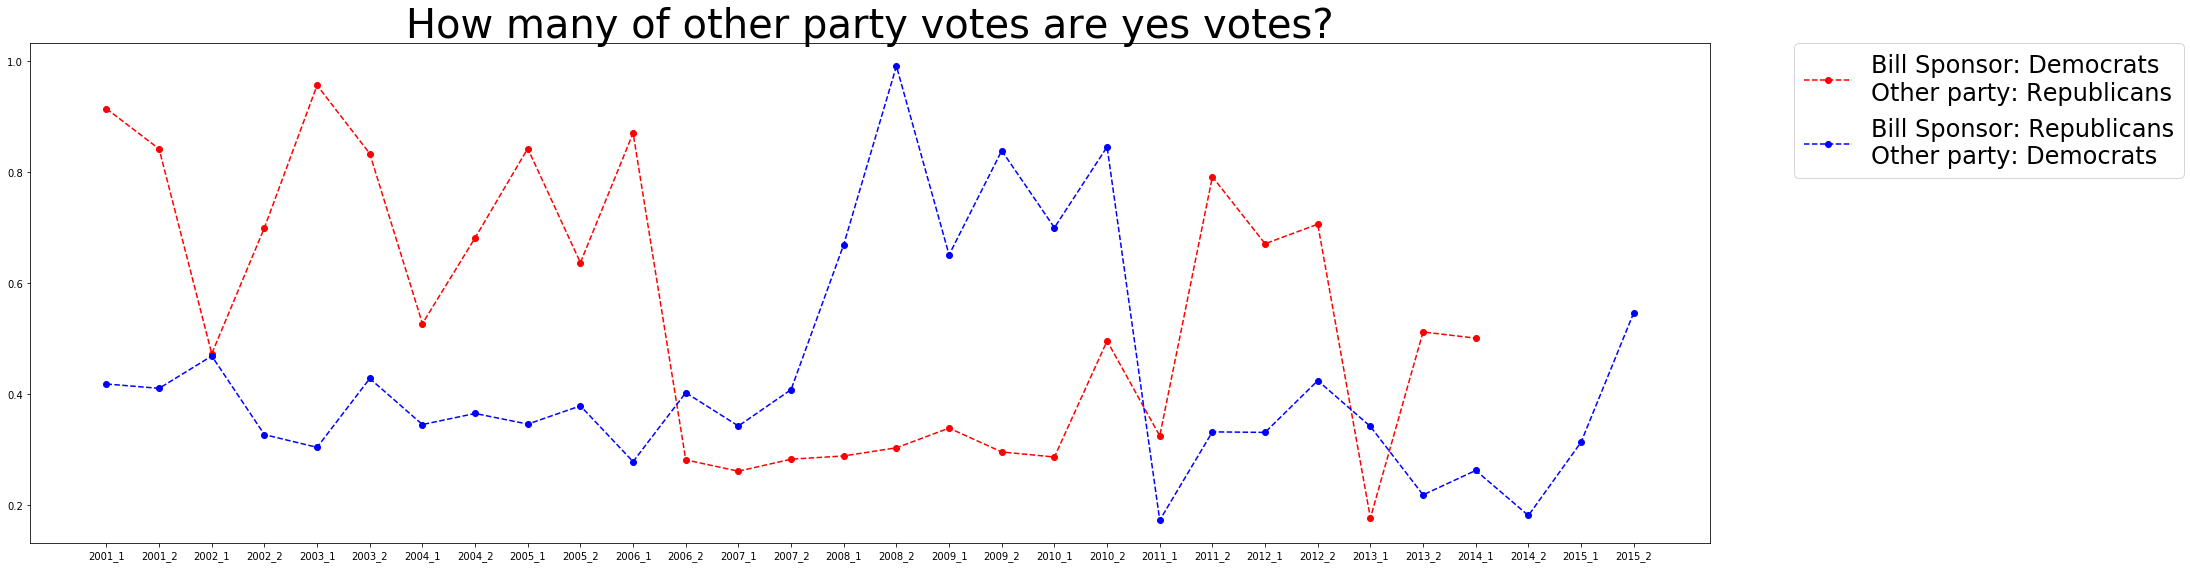

In [39]:
dem_result = result[result.sponsor_party == 'Dem']
rep_result = result[result.sponsor_party == 'Rep']

uniques = result[['year', 'half_year']].drop_duplicates().reset_index(drop=True)
all_values = uniques["year"].map(str) + "_" + uniques["half_year"].map(str)

_ = plt.figure(figsize=(24,8))

def plot_function(column, dem_result, rep_result, title):
    _ = plt.plot(dem_result[column].values, '--ro')
    _ = plt.plot(rep_result[column].values, '--bo')
    _ = plt.xticks([i for i in range(len(all_values))], all_values)
    
    _ = plt.title(title, fontsize=40)
    _ = plt.legend(['Bill Sponsor: Democrats\nOther party: Republicans', 
                    'Bill Sponsor: Republicans\nOther party: Democrats'], 
                   bbox_to_anchor=(1.05, 1), 
                   loc=2, 
                   borderaxespad=0.,
                   prop={'size': 24})
    _ = plt.tight_layout()
    
plot_function('share_of_yes_votes_opp_party', dem_result, rep_result, 
              'How many of other party votes are yes votes?')   

The previous steps lead to some interesting results in the UI: we can see that caching a table like `sqlContext.cacheTable("across_the_isle")` leads to the dataframe being in memory:

![Cached Table example](images/cached_table.png)

The RDD is now colored in green and the next task is an _InMemoryTableScan_.

In [40]:
sc.setJobGroup("Rolling_Average", "Rolling_Average")
query = """
select year, half_year, sponsor_party,
    sum(total_yes_votes_from_opp_party) over (partition by sponsor_party 
                                            order by year, half_year
                                            ROWS BETWEEN 3 PRECEDING AND CURRENT ROW) 
                                            /
    sum(total_votes_from_opp_party) over (partition by sponsor_party 
                                            order by year, half_year
                                            ROWS BETWEEN 3 PRECEDING AND CURRENT ROW) 
                                            
                                            as rolling_share_of_yes_votes_opp_party
from voting_behavior
order by 1,2,3
"""
result_df = spark.sql(query)
print("NumPartitions: {}".format(result_df.rdd.getNumPartitions()))
print(result_df.storageLevel)
result = result_df.toPandas()

NumPartitions: 58
Serialized 1x Replicated


The resulting dataframe of the rolling average calculation is distributed over 58 partitions - again a surprisingly high number since the dataframe is not that big with only 4 columns.

Its calculation is quite involved though as indicated by the size of DAG:

![Rolling average with two cached tables](images/rolling_average.png)

We can also see that we are leveraging two cached tables.

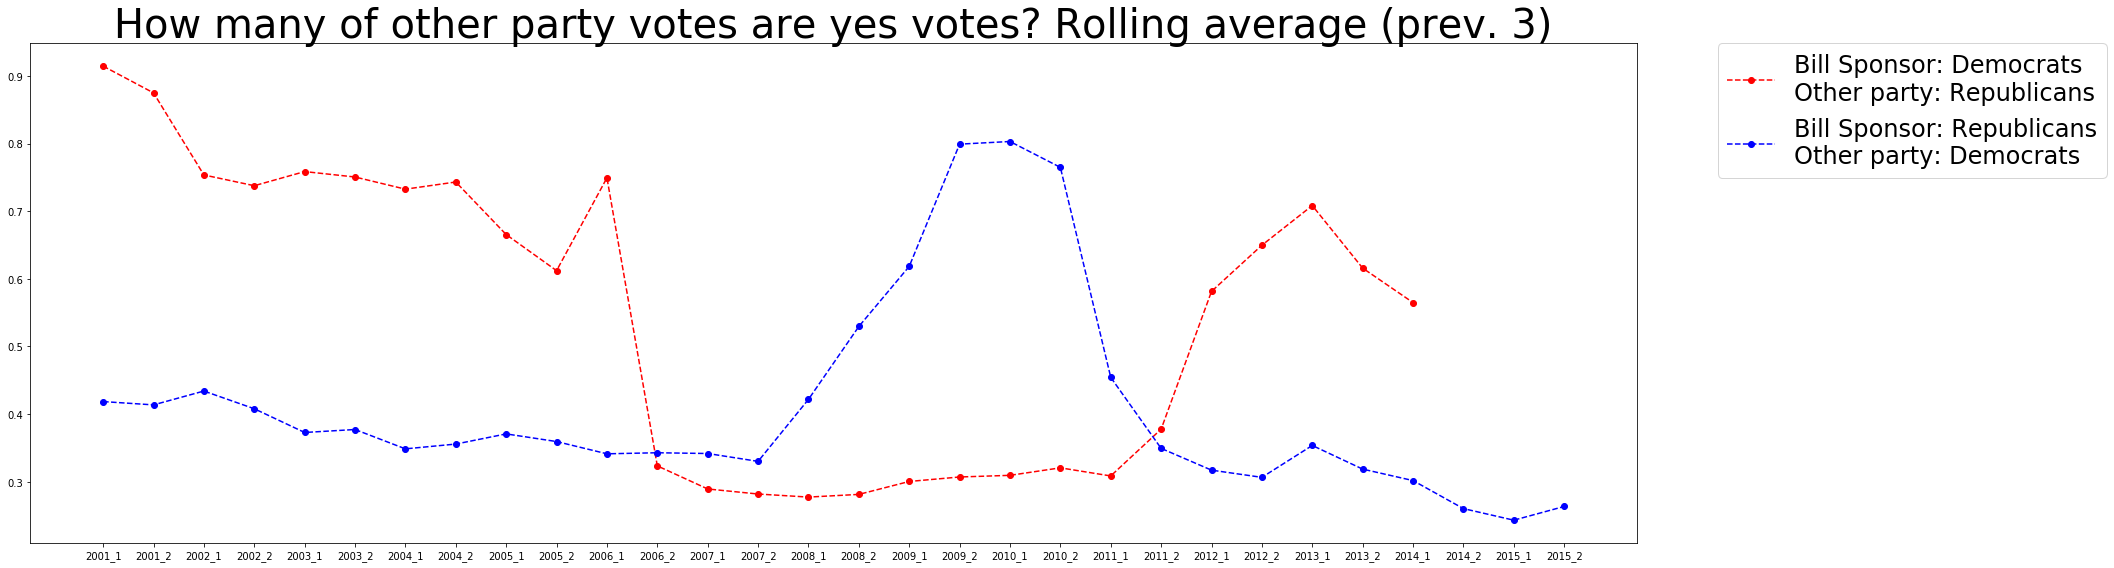

In [41]:
dem_result = result[result.sponsor_party == 'Dem']
rep_result = result[result.sponsor_party == 'Rep']

_ = plt.figure(figsize=(24,8))

def plot_function(column, dem_result, rep_result, title):
    _ = plt.plot(dem_result[column].values, '--ro')
    _ = plt.plot(rep_result[column].values, '--bo')
    _ = plt.xticks([i for i in range(len(all_values))], all_values)
    
    _ = plt.title(title, fontsize=40)
    _ = plt.legend(['Bill Sponsor: Democrats\nOther party: Republicans', 
                    'Bill Sponsor: Republicans\nOther party: Democrats'], 
                   bbox_to_anchor=(1.05, 1), 
                   loc=2, 
                   borderaxespad=0.,
                   prop={'size': 24})
    _ = plt.tight_layout()


plot_function('rolling_share_of_yes_votes_opp_party', dem_result, rep_result, 
              'How many of other party votes are yes votes? Rolling average (prev. 3)')   

#### Overall, it seems like there is a trend that the opposite party is less likely to votes Yes on the other party's bills. What is interesting to me though is that both parties show very similar behavior.

----

## Reshaping vote_db from having one row per vote to having one row per date.

In [42]:
sc.setJobGroup("Reshaping_data", "Reshaping_data")
long_data = vote_db.select(vote_db.vote_date, vote_db.vote_choice.cast('int'), vote_db.party)

wide_data = vote_db.select(vote_db.vote_date, vote_db.vote_choice.cast('int'), vote_db.party)\
            .groupBy("party").pivot("vote_date")\
            .avg("vote_choice")
        
print("Shape of long data & storage level:")
print((long_data.count(), len(long_data.columns)))
print(long_data.storageLevel)
print("Num Partitions:", long_data.rdd.getNumPartitions())

print("\nShape of wide data & storage level:")
print((wide_data.count(), len(wide_data.columns)))
print(wide_data.storageLevel)
print("Num Partitions:", wide_data.rdd.getNumPartitions())

Shape of long data & storage level:
(1393690, 3)
Serialized 1x Replicated
('Num Partitions:', 8)

Shape of wide data & storage level:
(7, 1796)
Serialized 1x Replicated
('Num Partitions:', 200)


#### While the storage level is the same, the wide data has many more partitions than the long data.

We get quite a few jobs for the pivoting of the data and I am not sure which job corresponds to which activity:

![Reshape Jobs](images/reshape.png)

------

# Time for some Machine Learning

We are going to train a Random Forest to predict recipients' total_receipts during a cycle. We are going to use a variety of features from the same time period or previous periods. We are also going to use cross-validation to pick the best model.

I used https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html as a guide.

In [43]:
sc.setJobGroup("Data_for_ML", "Data_for_ML")

query = """
with lagged_features as (
    select cycle, bonica_rid,
        LAG(num_givers, 1,0) OVER (ORDER BY cycle) AS prev_num_givers,
        LAG(total_receipts, 1,0) OVER (ORDER BY cycle) AS prev_total_receipts
    from filtered_dime_recps)

select cycle, 
        bonica_rid,
        float(total_receipts),
        int(num_givers),
        int(prev_num_givers),
        float(prev_total_receipts),
        int(ran_primary),
        int(ran_general),
        int(sum(sponsor)) as sponsored_bills, 
        int(sum(cosponsor)) as cosponsored_bills,
        sum(case
                when vote_choice = 6 then 0
                else 1
            end) as num_yes_votes
from joined_data
join lagged_features using (cycle, bonica_rid)
group by 1,2,3,4,5,6,7,8
"""
dataset = spark.sql(query)
dataset = dataset.drop("bonica_rid").na.drop() # Spark's RF does not work with missing values.
dataset.toPandas()

,cycle,total_receipts,num_givers,prev_num_givers,prev_total_receipts,ran_primary,ran_general,sponsored_bills,cosponsored_bills,num_yes_votes
0,2004,8.142950e+05,419,1,1.548500e+04,1,1,0,4,154
1,2006,6.598140e+05,439,333,1.036465e+06,1,1,0,4,130
2,2012,9.766688e+05,224,3305,2.091171e+05,1,1,0,8,180
3,2004,1.170367e+06,726,827,1.597260e+06,1,1,0,4,165
4,2006,1.499426e+07,6965,66,1.674100e+04,1,1,0,5,59
5,2008,1.033933e+06,426,162,6.761545e+04,1,1,1,44,487
6,2004,9.653990e+05,555,601,9.034440e+05,1,1,1,2,155
7,2012,7.013260e+05,231,200,4.514663e+05,0,0,0,5,108
8,2004,7.614430e+05,364,29,3.617800e+04,1,1,0,18,208
9,2010,1.309373e+06,656,34,1.749500e+04,1,1,2,41,424


In [44]:
sc.setJobGroup("ML_jobs", "ML_jobs")

feature_cols = ['num_givers',
                'prev_num_givers',
                'prev_total_receipts',
                'ran_primary',
                'ran_general',
                'sponsored_bills',
                'cosponsored_bills',
                'num_yes_votes']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [45]:
pipeline = Pipeline(stages=[assembler])
pipelineModel = pipeline.fit(dataset)
dataset = pipelineModel.transform(dataset)

# Keep relevant columns
selectedcols = ["total_receipts", "features"]
dataset = dataset.select(selectedcols)
display(dataset)

trainingData, testData = dataset.randomSplit([0.7, 0.3], seed = 100)

print("trainingData is size: {}".format(trainingData.count()))
print("testData is size: {}".format(testData.count()))

DataFrame[total_receipts: float, features: vector]

trainingData is size: 1943
testData is size: 855


In [46]:
rf = RandomForestRegressor(labelCol="total_receipts", 
                           featuresCol="features")

print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: total_receipts)
maxBins: Max number of bins for discretizing continuous features

In [47]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [1, 3])
             .addGrid(rf.featureSubsetStrategy, ["all", "sqrt"])
             .addGrid(rf.numTrees, [50, 200])
             .build())

evaluator = RegressionEvaluator(predictionCol="prediction",
                                labelCol="total_receipts",
                                metricName="rmse")

In [48]:
# Create 3-fold CrossValidator
cv = CrossValidator(estimator=rf, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, 
                    numFolds=3)

# Run cross validations
cvModel = cv.fit(trainingData)

In [49]:
# According to https://stackoverflow.com/a/41746346, Pyspark before Spark 2.3 doesn't store
# upstream estimator params, but we should be able to retrieve it directly from the JVM object.
print("We use version: {}".format(sc.version))

print("Max depth of best model is: {}".format(cvModel.bestModel._java_obj.getMaxDepth()))
print("Num Trees of best model is: {}".format(cvModel.bestModel._java_obj.getNumTrees()))

We use version: 2.2.1
Max depth of best model is: 3
Num Trees of best model is: 50


In [50]:
# Average cross-validation metrics for each paramMap in CrossValidator.estimatorParamMaps, 
# in the corresponding order.
for i in range(len(paramGrid)):
    print("Model with config:\n\t {}".format(paramGrid[i]))
    print("Achieved avg metric of:\n\t {}".format(cvModel.avgMetrics[i]))
    print("")

Model with config:
	 {Param(parent=u'RandomForestRegressor_4e3da606ccc2694d9a7a', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent=u'RandomForestRegressor_4e3da606ccc2694d9a7a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 1, Param(parent=u'RandomForestRegressor_4e3da606ccc2694d9a7a', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all'}
Achieved avg metric of:
	 1994139.95827

Model with config:
	 {Param(parent=u'RandomForestRegressor_4e3da606ccc2694d9a7a', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent=u'RandomForestRegressor_4e3da606ccc2694d9a7a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 1, Param(parent=u'RandomForestRe

In [51]:
# How well does our model do on the test data?
predictions = cvModel.transform(testData)
predictions.printSchema()

selected = predictions.select("total_receipts", "prediction", "features")
selected.take(1)

evaluator.evaluate(predictions)

root
 |-- total_receipts: float (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = true)



[Row(total_receipts=965399.0, prediction=1252947.190355242, features=DenseVector([555.0, 601.0, 903444.0, 1.0, 1.0, 1.0, 2.0, 155.0]))]

1878114.3645291112

In [66]:
# Feature importances of final model
feat_imp = cvModel.bestModel.featureImportances
feat_imp_list = []
for i in feat_imp.indices:
    feat_imp_list.append((feature_cols[int(i)], feat_imp[int(i)]))
    
feat_imp_list = sorted(feat_imp_list, key=lambda x:(-x[1], x[0])) # https://stackoverflow.com/a/14466141

for feat, imp in feat_imp_list:
    print("Feature {} has importance of: {}".format(feat, imp))

Feature num_givers has importance of: 0.850209335873
Feature num_yes_votes has importance of: 0.0588344185109
Feature cosponsored_bills has importance of: 0.03486099642
Feature ran_general has importance of: 0.0191346706673
Feature prev_total_receipts has importance of: 0.0165505724899
Feature ran_primary has importance of: 0.010925077666
Feature prev_num_givers has importance of: 0.00917857367218
Feature sponsored_bills has importance of: 0.000306354700657


## ML Summary

We used a 3-fold CrossValidator to train and select the best performing Random Forest. The goal was to predict the recipients' total_receipts during a cycle. The features we used were 'num_givers' (same cycle), 'prev_num_givers' (previous cycle), 'prev_total_receipts' (previous cycle), 'ran_primary' (same cycle), 'ran_general' (same cycle), 'sponsored_bills' (same cycle), 'cosponsored_bills' (same cycle), 'num_yes_votes' (same cycle). The evaluation metric was RMSE since this is a regression problem. The final model achieved a RMSE of 1,878,114.36 - which seems quite high. However, in order to really evaluate the model's RMSE a better understanding of the distribution of total_receipts would have been helpful. Are they strong outliers that hurt the modeling process (probably so; thinking of presidential campaigns).

A Random Forest is an ensemble method that leverages decision trees as the individual learners. Instead of being able to select from all features when deciding the next split, the decision trees in Random Forests only have access to a subgroup of the features. Furthermore, each tree is not trained on the whole training set - instead, every tree gets trained on a bootstrap of the training set. For evaluation, the trees' predictions are aggregated to make the final prediction. 

The final model's most important feature was the number of givers in the same cycle followed by number of yes votes in the cycle but with much less importance. Looking back, this seems like a result that can be expected and brings up some questions about the feature selection: obviously, having more individuals contribute leads to higher total receipts. Also, we only know the number of givers when the election campaign is over - which is the same time when we know the amount of total receipts. Therefore, this model would not be very useful in practice. A better use case of the model could be to use it for imputation of missing total receipts values.

What is interesting though is that the number of givers in the previous cycle did not have greater importance. One could argue that if the current cycle's number of givers has an impact on the outcome, we could expect a high importance for the previous cycle's amount of givers as well. Maybe the election cycles are too long and separate from each other for the number of givers to matter across cycles? Or politicians can quickly fall out of favor / start a movement - leading to total receipts that are not very dependent on the previous cycle?

----

The whole training and evaluation process spanned across many jobs (159). I did not see an obvious way to differentiate which jobs belong to cross-validation, evaluation, etc. It was interesting for me to see though how the jobs switch between being related to Random Forests directly and the underlying Decision Trees:

![ML Jobs](images/ml_jobs.png)